In [1]:
# get everything imported and organized 

import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, linregress
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# Define data directories
data_dir = '/u/project/petersen/data/ocs/bids/derivatives/ExtractedTS/Schaefer419'
arm_a_dir = os.path.join(data_dir, 'ArmA')
arm_b_dir = os.path.join(data_dir, 'ArmB')
behavioral_data_path = '/u/home/n/npeterse/ocs_behavioral_data.csv'
node_labels_path = '/u/home/n/npeterse/NodeOrder.csv'

# Load data
behavioral_data = pd.read_csv(behavioral_data_path)
node_labels_df = pd.read_csv(node_labels_path)
node_labels = node_labels_df.columns.tolist()

# Clean up column names and ensure 'Participant ID' is consistent
behavioral_data.columns = behavioral_data.columns.str.strip()
behavioral_data['Participant ID'] = behavioral_data['Participant ID'].astype(str).str.strip()

# List of subject IDs
subject_ids = [
    '36002', '36035', '36039', '36042', '36049', '36053', '36055', '36057', 
    '36059', '36063', '36073', '36074', '36077', '36082', '36094', '36118', 
    '36123', '36124', '36125', '36127', '36128', '36129', '36130', '36145', 
    '36146', '36159', '36165', '36170', '36175', '36178', '36180', '36181'
]

unique_subject_ids = set(subject_ids)

# List all files in each directory
files_a = [f for f in os.listdir(arm_a_dir) if f.endswith('_SchTS.txt')]
files_b = [f for f in os.listdir(arm_b_dir) if f.endswith('_SchTS.txt')]

# Initialize a dictionary to store matched behavioral data for each subject
matched_behavioral_data = {sub_id: {'ArmA_DRSP_TOTAL': None, 'ArmB_DRSP_TOTAL': None} for sub_id in unique_subject_ids}

# Function to match behavioral data to subjects
def match_behavioral_data():
    for _, row in behavioral_data.iterrows():
        subject_id = row['Participant ID']
        intervention = row['Intervention']
        drsp_total = row['DRSP Total']

        if subject_id in matched_behavioral_data:
            if intervention == 'A':
                matched_behavioral_data[subject_id]['ArmA_DRSP_TOTAL'] = drsp_total
            elif intervention == 'B':
                matched_behavioral_data[subject_id]['ArmB_DRSP_TOTAL'] = drsp_total

match_behavioral_data()

# Create a dictionary to store file paths by subject ID
subject_files = {}

# Helper function to extract subject ID from filename
def extract_subject_id(filename):
    return filename.split('_')[0][4:9]  # Extract first 5 digits after 'sub-'

# Populate the dictionary with ArmA and ArmB files
for file in files_a:
    subject_id = extract_subject_id(file)
    if subject_id not in subject_files:
        subject_files[subject_id] = {}
    subject_files[subject_id]['ArmA'] = os.path.join(arm_a_dir, file)

for file in files_b:
    subject_id = extract_subject_id(file)
    if subject_id not in subject_files:
        subject_files[subject_id] = {}
    subject_files[subject_id]['ArmB'] = os.path.join(arm_b_dir, file)

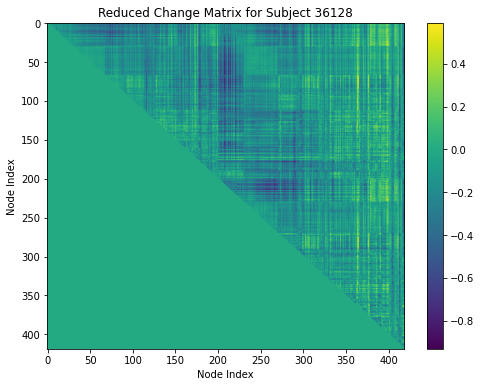

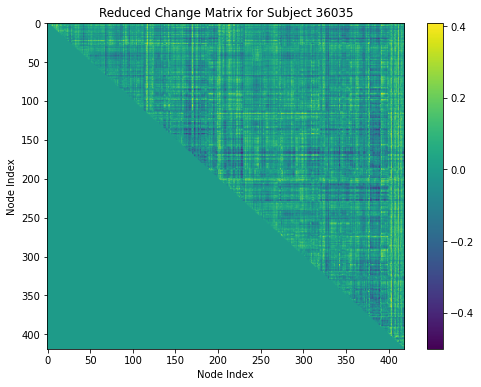

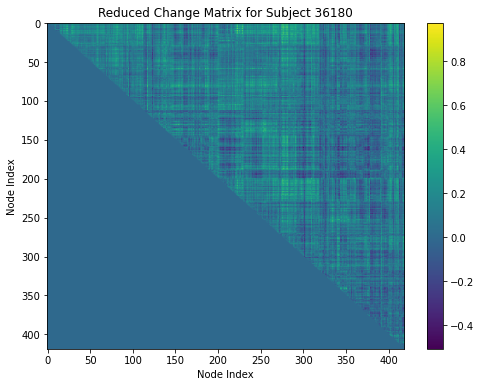

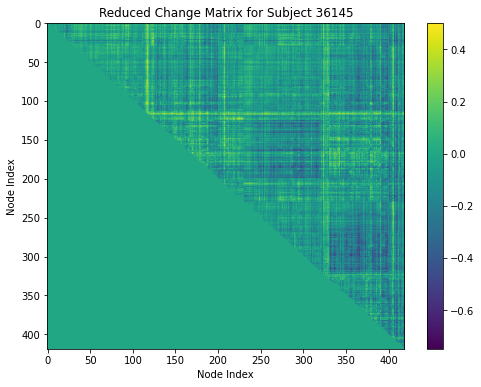

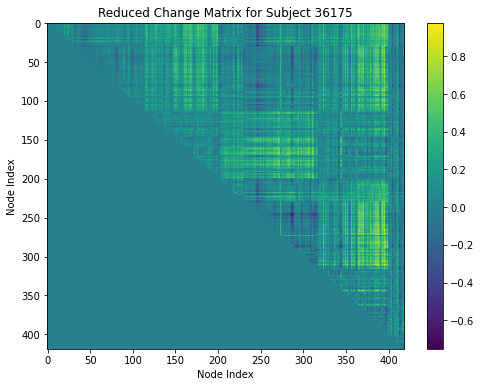

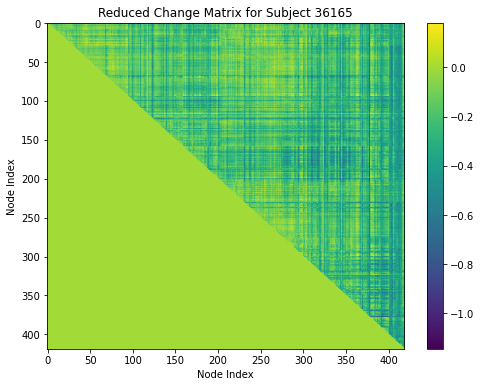

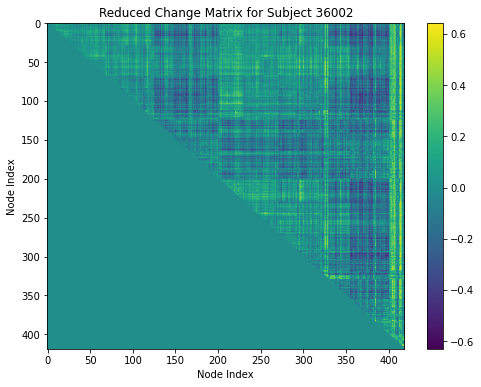

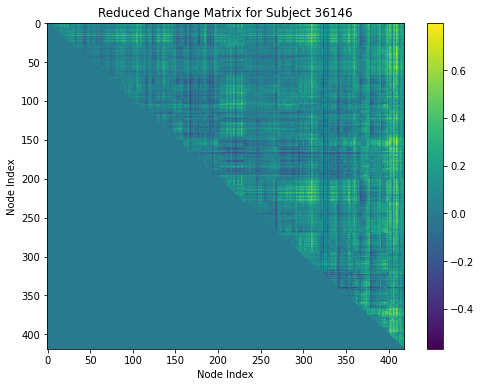

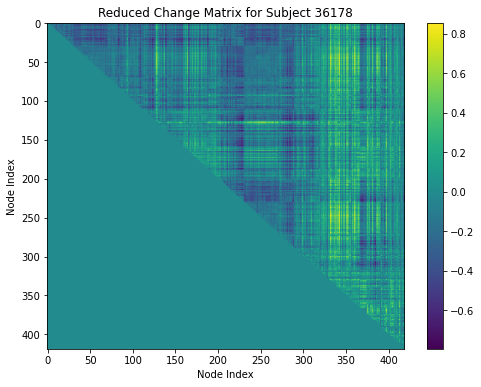

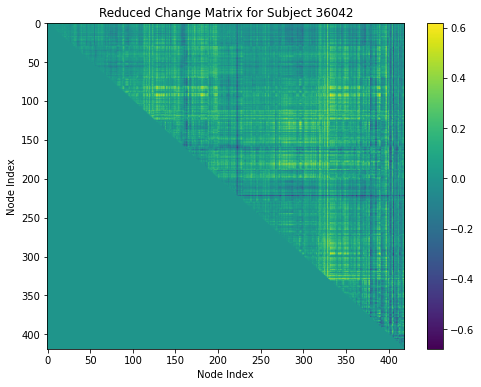

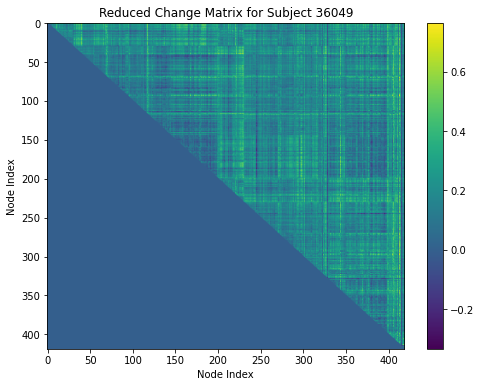

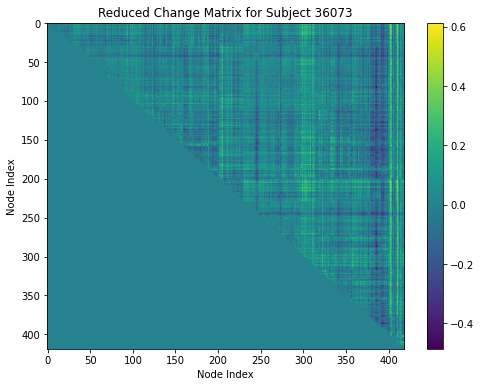

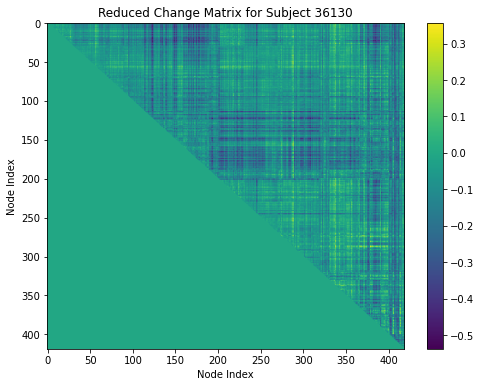

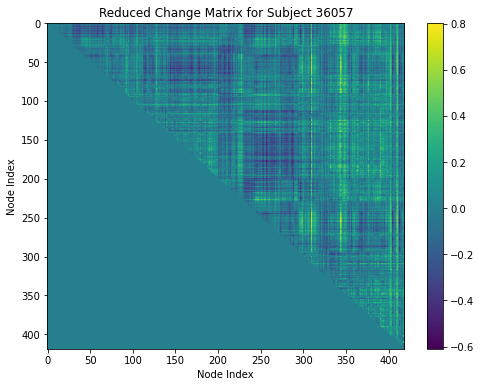

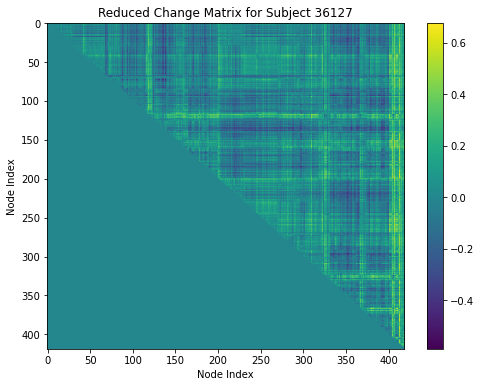

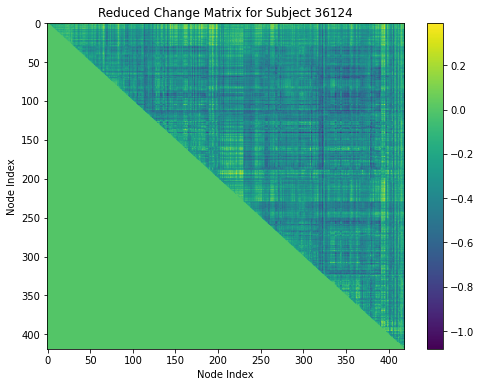

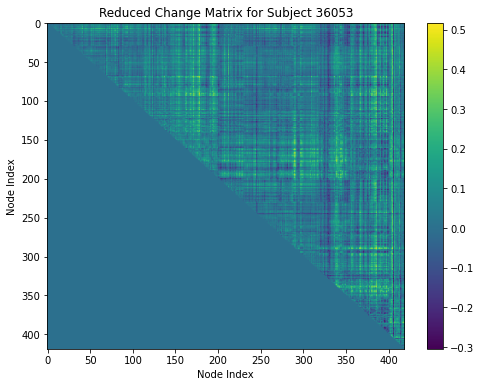

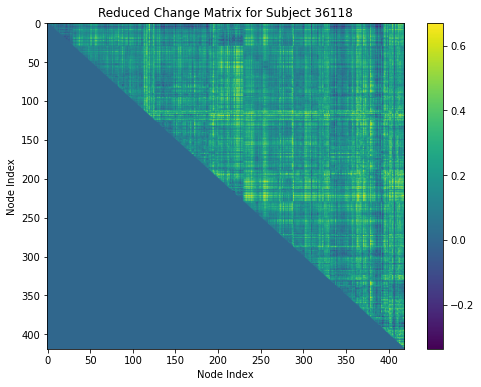

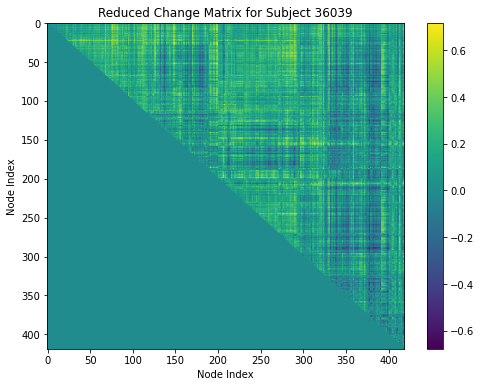

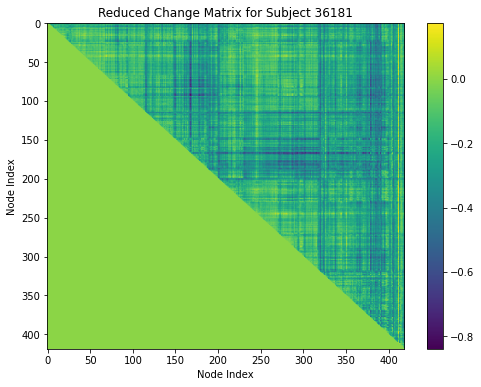

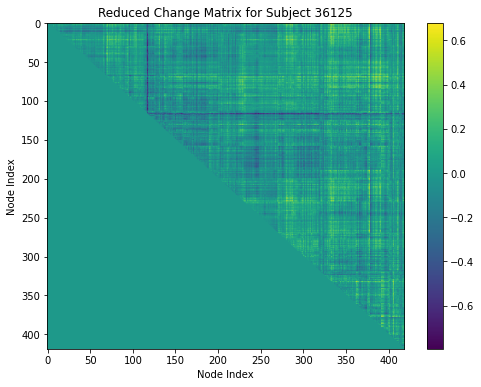

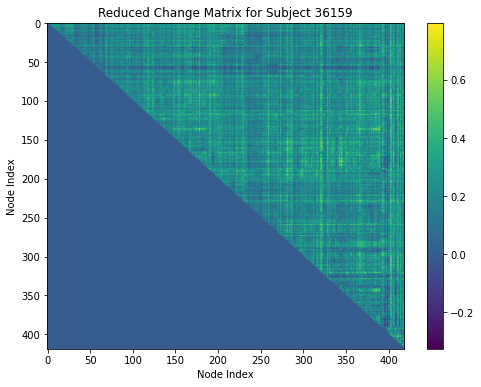

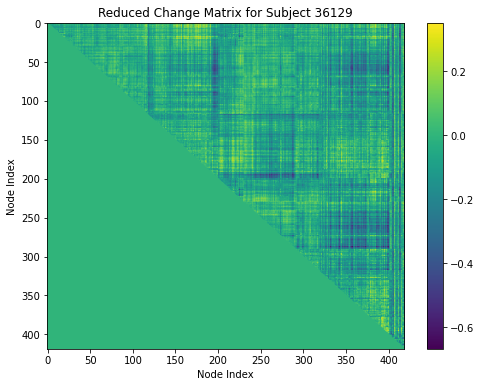

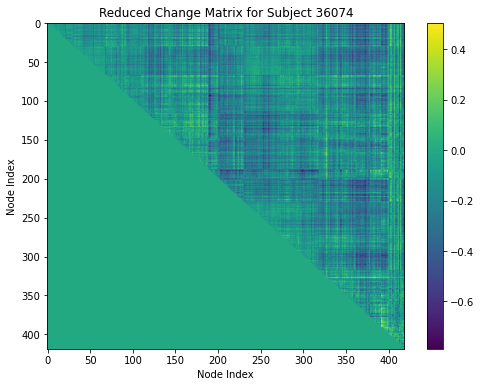

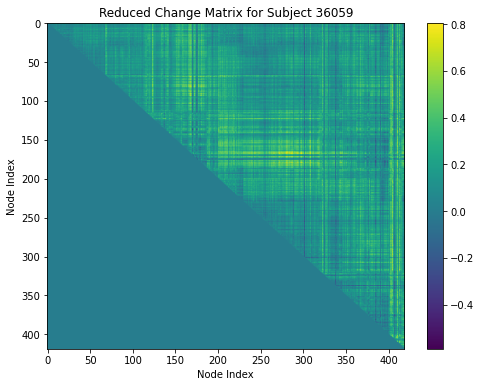

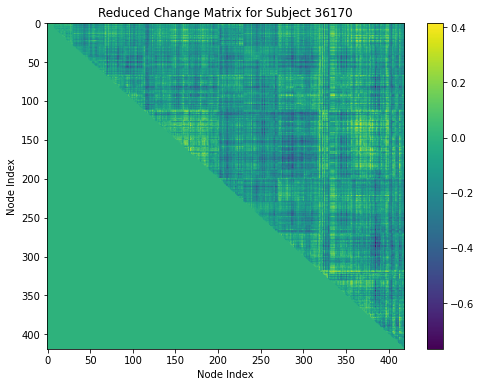

In [2]:
# make some pretty matrices - one matrix per person per study arm

# shape the data
def load_and_trim_data(file_path):
    data = np.loadtxt(file_path)
    return data[:419, :] if data.shape[0] > 419 else data

# run the correlations
def compute_correlation_matrix(data):
    return np.corrcoef(data, rowvar=False)

# show the correlations
def visualize_matrix(matrix, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Node Index')
    plt.ylabel('Node Index')
    plt.show()

# Ensure output directory exists
os.makedirs('correlation_matrices', exist_ok=True)

flattened_unique_changes = []

# Process each matched subject
for subject_id in unique_subject_ids:
    if subject_id in subject_files and 'ArmA' in subject_files[subject_id] and 'ArmB' in subject_files[subject_id]:
        scan_a_data = load_and_trim_data(subject_files[subject_id]['ArmA'])
        scan_b_data = load_and_trim_data(subject_files[subject_id]['ArmB'])

        corr_matrix_a = compute_correlation_matrix(scan_a_data)
        corr_matrix_b = compute_correlation_matrix(scan_b_data)

        # Calculate the change matrix and extract upper triangle
        change_matrix = corr_matrix_b - corr_matrix_a
        upper_tri_indices = np.triu_indices_from(change_matrix, k=1)
        unique_upper_changes = change_matrix[upper_tri_indices]

        # Append the unique changes to the list
        flattened_unique_changes.append(unique_upper_changes)
        
        # uncomment the line below if you want to see the whole (redunant) matrix
        #visualize_matrix(change_matrix, f'Original Change Matrix for Subject {subject_id}')
        
        # Extract only the upper triangle of the matrix (excluding diagonal)
        upper_tri_indices = np.triu_indices_from(change_matrix, k=1)
        unique_upper_changes = change_matrix[upper_tri_indices]
        
        # Visualize reduced matrix with unique upper triangle
        reduced_matrix = np.zeros_like(change_matrix)
        reduced_matrix[upper_tri_indices] = unique_upper_changes
        visualize_matrix(reduced_matrix, f'Reduced Change Matrix for Subject {subject_id}')
        
    else:
        print(f"Warning: Missing scans for subject ID {subject_id} in one or both arms.")



In [3]:
# now we will start to incorporate DRSP data. in a separate notebook, I ran PCA on the DRSPs alone and didn't find
# a better loading than just using the total score. so, this block leaves the option open to look at individual 
# items
# but should be written to only use the total score. it might be cool to look at the full DRSP dataset some
# other time and see if with more data, anything else takes shape...

# make a dictionary
data_for_df = []

# list out all the columns just in case you want to look at specific symptoms
drsp_columns = ['DRSP Total', 'AVG DRSP 1', 'AVG DRSP 2', 'AVG DRSP 3', 'AVG DRSP 4',
                'AVG DRSP 5', 'AVG DRSP 6', 'AVG DRSP 7', 'AVG DRSP 8', 'AVG DRSP 9',
                'AVG DRSP 10', 'AVG DRSP 11', 'AVG DRSP 12', 'AVG DRSP 13', 'AVG DRSP 14']

# Process each matched subject
for subject_id in unique_subject_ids:
    if subject_id in subject_files and 'ArmA' in subject_files[subject_id] and 'ArmB' in subject_files[subject_id]:
        # Load and compute correlation matrix for both scans
        scan_a_data = load_and_trim_data(subject_files[subject_id]['ArmA'])
        scan_b_data = load_and_trim_data(subject_files[subject_id]['ArmB'])
        
        corr_matrix_a = compute_correlation_matrix(scan_a_data)
        corr_matrix_b = compute_correlation_matrix(scan_b_data)
        
        # Measure changes between sessions
        change_matrix = corr_matrix_b - corr_matrix_a
        
        # Extract only the upper triangle of the matrix (excluding diagonal)
        upper_tri_indices = np.triu_indices_from(change_matrix, k=1)
        unique_upper_changes = change_matrix[upper_tri_indices]
        
        # Find corresponding behavioral data for the subject
        subject_behavioral_data = behavioral_data[behavioral_data['Participant ID'] == subject_id]
        
        # Check if behavioral data is available for the subject
        if not subject_behavioral_data.empty:
            # Extract DRSP scores for all items and total (should be a single row)
            drsp_scores = subject_behavioral_data[drsp_columns].iloc[0].tolist()
            
            # Append data to list for DataFrame
            data_for_df.append([subject_id, unique_upper_changes] + drsp_scores)
        else:
            print(f"Missing behavioral data for subject {subject_id}")
    else:
        print(f"Warning: Missing scans for subject ID {subject_id} in one or both arms.")


# Create DataFrame from the collected data
df_columns = ['Subject_ID', 'Unique_Changes'] + drsp_columns
df = pd.DataFrame(data_for_df, columns=df_columns)

# Display the DataFrame
#print(df)

# Check for NaN values in the DataFrame
#print("\nNaN counts per column in the DataFrame:")
#print(df.isna().sum())


Number of features: 87571
Number of node pairs: 175561
       Feature   Node Pair  Correlation   P-Value
85426    85426  (111, 370)     0.739969  0.000016
87010    87010  (295, 147)     0.665348  0.000208
80471    80471   (100, 24)     0.652214  0.000306
4664      4664   (12, 225)     0.634336  0.000501
84508    84508  (109, 342)     0.618796  0.000752
4661      4661   (12, 222)     0.618349  0.000760
18434    18434  (213, 418)     0.615821  0.000811
19912    19912  (217, 307)     0.614096  0.000846
75194    75194  (289, 101)     0.612958  0.000871
80232    80232   (99, 111)     0.612727  0.000876
78531    78531   (95, 288)     0.612183  0.000888
85264    85264  (111, 295)     0.611769  0.000897
53510    53510  (260, 350)     0.611150  0.000911
73579    73579  (285, 329)     0.603796  0.001091
2352      2352    (6, 127)     0.603188  0.001107
4609      4609     (12, 1)     0.603187  0.001107
4688      4688    (12, 50)     0.600626  0.001177
73565    73565  (285, 123)     0.599970  0.00

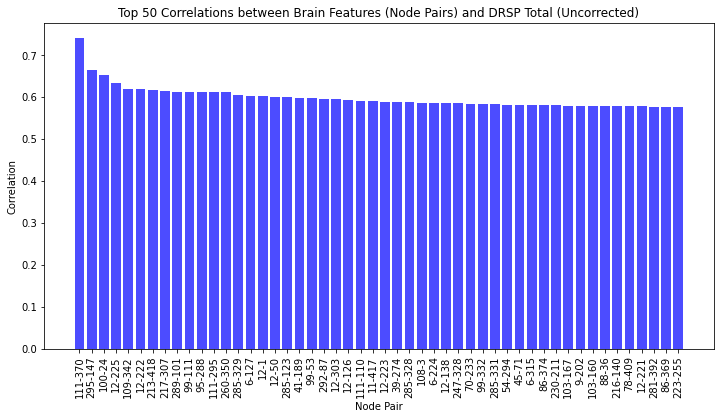

In [4]:
# taking a simple look at univariate correlations... although come to think of it this is probably 
# not ending up in the ms. leave it here for now

# get the node labels and carefully attach them to the correct nodes 
node_labels = pd.read_csv(node_labels_path, header=None).values.flatten()
num_nodes = len(node_labels)
node_pairs = [(node_labels[i], node_labels[j]) for i in range(num_nodes) for j in range(num_nodes)]

# make sure the brain and behavioral data are formatted correctly 
brain_data = np.array(df['Unique_Changes'].tolist())  
drsp_total = df['DRSP Total'].values 
brain_data_flattened = brain_data.reshape(brain_data.shape[0], -1)  
print(f"Number of features: {brain_data_flattened.shape[1]}")
print(f"Number of node pairs: {len(node_pairs)}")

# Ensure that the node_pairs list matches the flattened matrix dimensions
if len(node_pairs) != brain_data_flattened.shape[1]:
    node_pairs = node_pairs[:brain_data_flattened.shape[1]]  # Trim or extend as needed

# generate brain-behavior correlations
correlations = []
p_values = []

for i in range(brain_data_flattened.shape[1]):
    corr, p_val = pearsonr(brain_data_flattened[:, i], drsp_total)
    correlations.append(corr)
    p_values.append(p_val)

# Convert to numpy arrays for easier manipulation
correlations = np.array(correlations)
p_values = np.array(p_values)

# Create a DataFrame for easy visualization and sorting
results_df = pd.DataFrame({
    'Feature': np.arange(brain_data_flattened.shape[1]),
    'Node Pair': node_pairs,  # Add the node pair information here
    'Correlation': correlations,
    'P-Value': p_values
})

# Sort results by absolute correlation value to see the strongest relationships
results_df_sorted = results_df.sort_values(by='Correlation', key=np.abs, ascending=False)

# Display the top 50 strongest correlations (uncorrected)
print(results_df_sorted.head(50))

# Optional: Plot the top 50 correlations
top_50_results = results_df_sorted.head(50)

plt.figure(figsize=(12, 6))
plt.bar(range(len(top_50_results)), top_50_results['Correlation'], color='blue', alpha=0.7)
plt.xticks(range(len(top_50_results)), [f"{pair[0]}-{pair[1]}" for pair in top_50_results['Node Pair']], rotation=90)
plt.title('Top 50 Correlations between Brain Features (Node Pairs) and DRSP Total (Uncorrected)')
plt.xlabel('Node Pair')
plt.ylabel('Correlation')
plt.show()

In [17]:
# this PCA produces something useful. you will run PCA on a MUCH smaller feature set, then look at the relationship
# between those features and DRSP scores

# start by strictly thresholding the features you will enter into PCA
significant_indices = np.where(p_values < 0.001)[0]
brain_data_thresholded = brain_data_flattened[:, significant_indices]

# make sure the shape of the data makes sense -- right number of participants and features
print("Shape of thresholded brain data:", brain_data_thresholded.shape)

# reshape Y (DRSP scores) into 2D array for compatibility with fc matrices
Y = df['DRSP Total'].values.reshape(-1, 1)  

# make sure that shape also makes sense
print("Shape of Y (DRSP Total):", Y.shape)

# run PCA
pca = PCA(n_components=5)  # <- you can adjust the number of components here, but only PC1 matters so don't
brain_pca = pca.fit_transform(brain_data_thresholded)

# Calculate correlations and p-values between each PCA component and DRSP scores
print("\nPCA Results:")
for i in range(brain_pca.shape[1]):
    corr, p_val = pearsonr(brain_pca[:, i], Y.flatten())
    print(f"Correlation between PCA component {i+1} and DRSP scores: r = {corr:.3f}, p = {p_val:.3e}")

# I accidentally redefined this variable and then I use this for the rest of the code blocks, either fix all
# or just leave it. but it is redundant
significant_indices_001 = np.where(p_values < 0.001)[0]
num_significant_features = len(significant_indices_001)
print(f"Number of features that survive the p = 0.001 threshold: {num_significant_features}")

# lets get the node labels back on... not sure why they disappeared

n_nodes = len(node_labels)  
node_pairs = list(combinations(node_labels, 2))  # Generate all possible pairs (excluding self-pairs)

assert len(node_pairs) == brain_data_flattened.shape[1], "Mismatch between number of node pairs and features!"

# look at Pearson correlations between each surviving feature and DRSP scores

for index in significant_indices_001:
    feature_data = brain_data_flattened[:, index]
    corr, p_val = pearsonr(feature_data, Y.flatten())
    node_pair = node_pairs[index]  # Mapping feature index to node pair
    print(f"Feature: {node_pair}, Correlation with DRSP: r = {corr:.3f}, p = {p_val:.3e}")

Shape of thresholded brain data: (26, 13)
Shape of Y (DRSP Total): (26, 1)

PCA Results:
Correlation between PCA component 1 and DRSP scores: r = -0.756, p = 7.811e-06
Correlation between PCA component 2 and DRSP scores: r = 0.125, p = 5.443e-01
Correlation between PCA component 3 and DRSP scores: r = -0.040, p = 8.462e-01
Correlation between PCA component 4 and DRSP scores: r = 0.170, p = 4.064e-01
Correlation between PCA component 5 and DRSP scores: r = -0.076, p = 7.137e-01
Number of features that survive the p = 0.001 threshold: 13
Feature: ('12', '263'), Correlation with DRSP: r = 0.618, p = 7.604e-04
Feature: ('12', '266'), Correlation with DRSP: r = 0.634, p = 5.011e-04
Feature: ('216', '341'), Correlation with DRSP: r = 0.616, p = 8.106e-04
Feature: ('220', '341'), Correlation with DRSP: r = 0.614, p = 8.464e-04
Feature: ('88', '341'), Correlation with DRSP: r = 0.611, p = 9.109e-04
Feature: ('131', '341'), Correlation with DRSP: r = 0.613, p = 8.709e-04
Feature: ('337', '343')

PC1 explains 67.25% of the variance
PC2 explains 12.83% of the variance
PC3 explains 6.13% of the variance
PC4 explains 3.81% of the variance
PC5 explains 2.44% of the variance


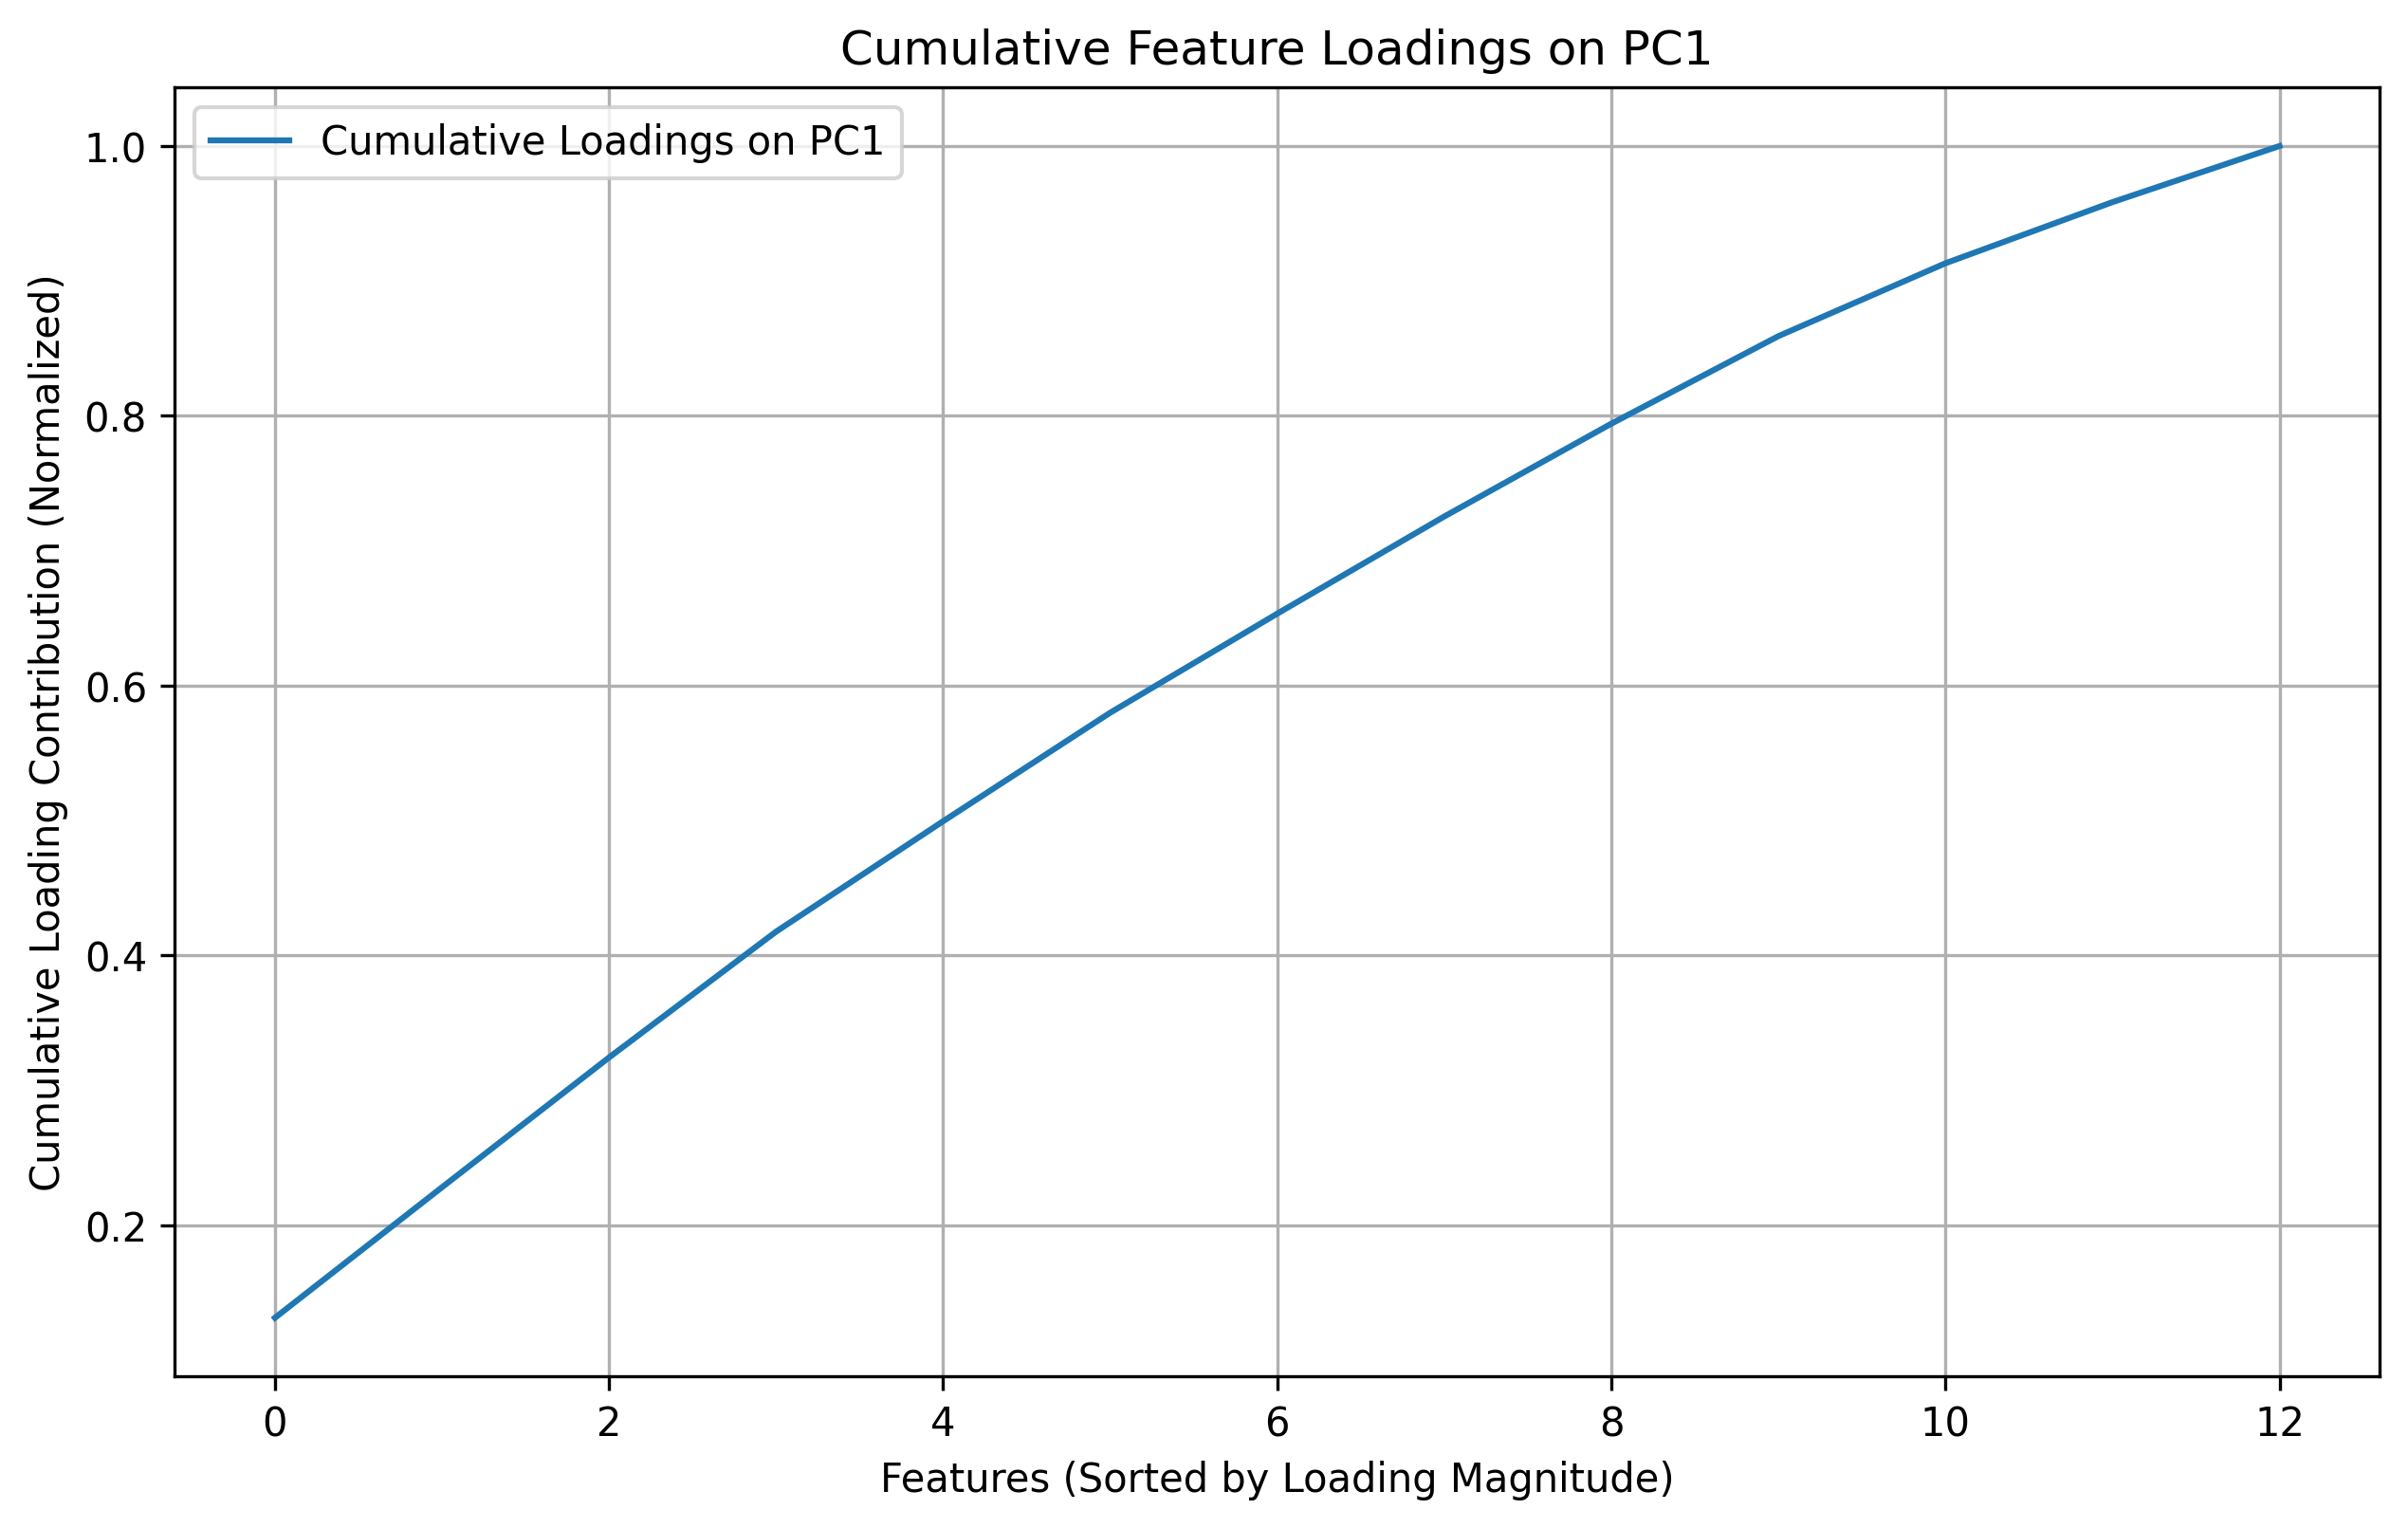

In [21]:
# visualize feature loadings...

# Print the % variance explained by each of the 5 PCs
explained_variance = pca.explained_variance_ratio_ * 100  # Convert to percentage
for i, variance in enumerate(explained_variance, start=1):
    print(f"PC{i} explains {variance:.2f}% of the variance")


# Extract the loadings for the first principal component (PC1)
pc1_loadings = np.abs(pca.components_[0])  # Loadings for PC1 (absolute values for magnitude)

# Sort the loadings in descending order (optional, for clearer visualization)
sorted_loadings = np.sort(pc1_loadings)[::-1]

# Calculate cumulative sum of the sorted loadings
cumulative_loadings = np.cumsum(sorted_loadings)

# Normalize to get the cumulative explained variance contribution
cumulative_loadings_normalized = cumulative_loadings / cumulative_loadings[-1]

# Plot cumulative feature loadings on PC1
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(cumulative_loadings_normalized, label='Cumulative Loadings on PC1')
plt.title('Cumulative Feature Loadings on PC1')
plt.xlabel('Features (Sorted by Loading Magnitude)')
plt.ylabel('Cumulative Loading Contribution (Normalized)')
plt.grid(True)
plt.legend()
plt.show()

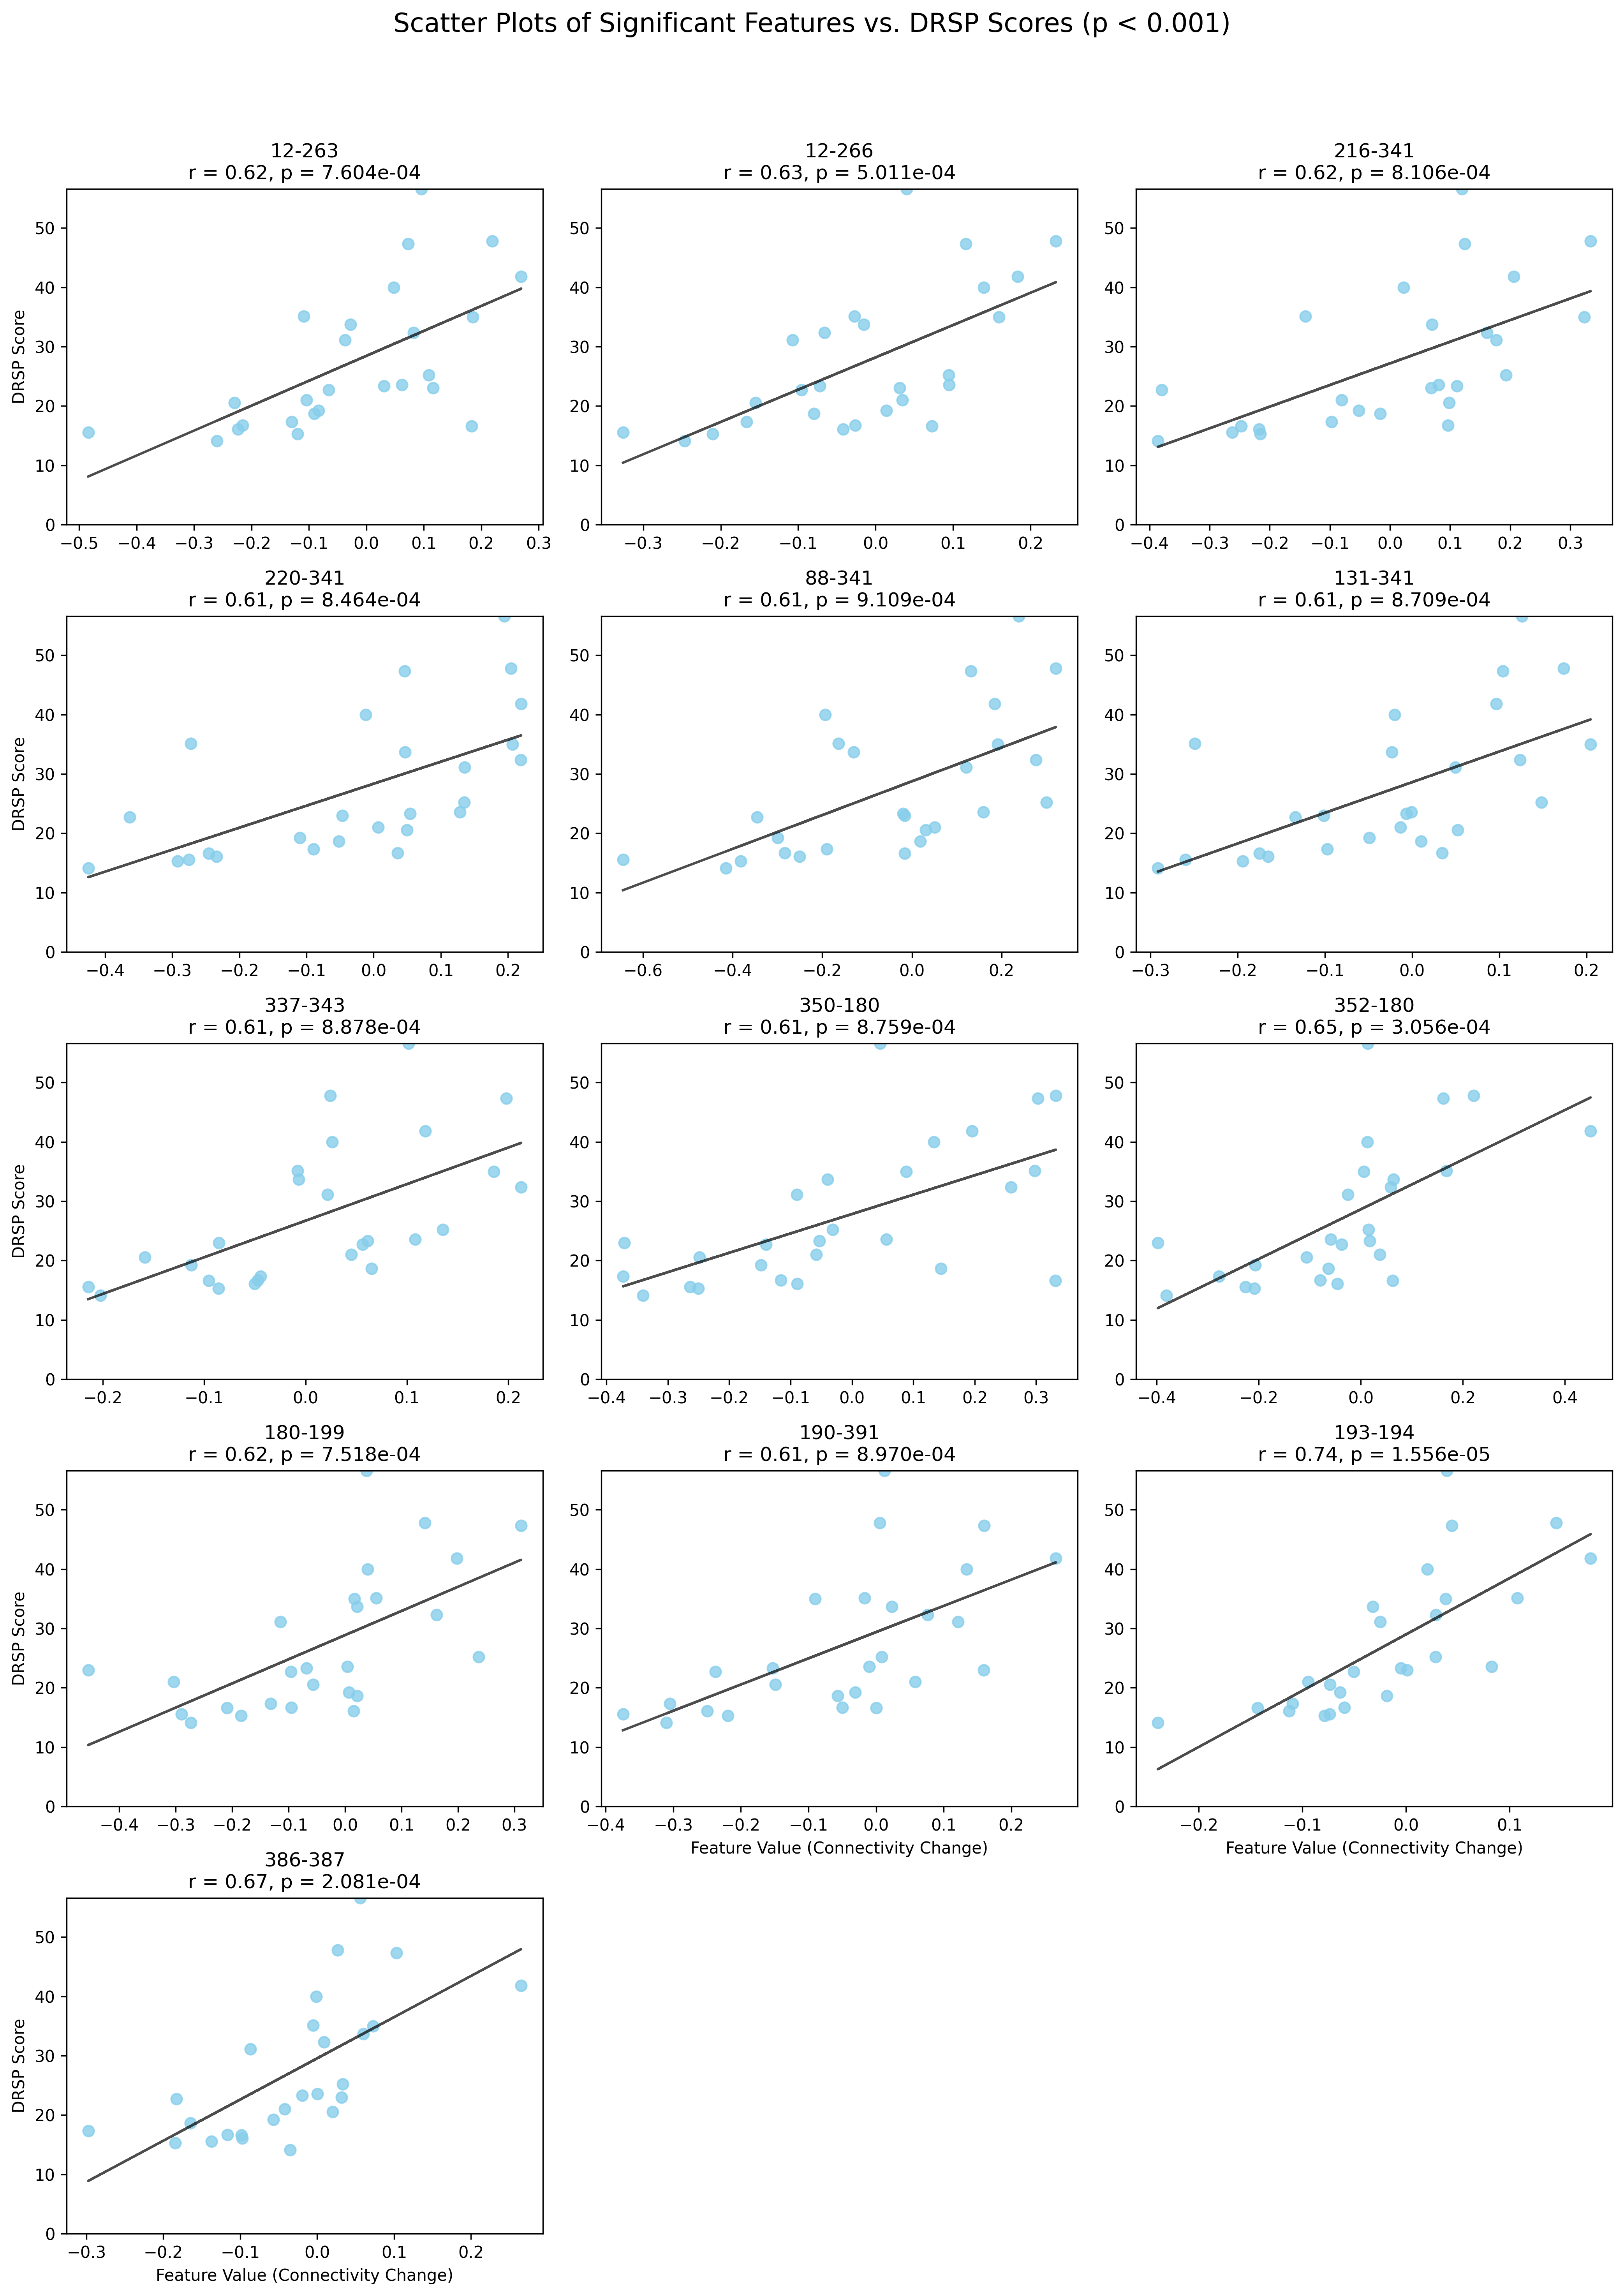

In [42]:
# visualize the DRSP-connectivity correlations

# Adjust figure size to fit 2 or 3 plots per row
plt.figure(figsize=(14, 20),dpi=300)  

# Loop through 13 plots and arrange in a grid with 2 or 3 plots per row
for i, index in enumerate(significant_indices_001[:13]):
    feature_data = brain_data_flattened[:, index]
    drsp_scores = Y.flatten()
    
    # Compute Pearson correlation
    corr, p_val = pearsonr(feature_data, drsp_scores)
    
    # Compute line of best fit
    slope, intercept, r_value, p_value, std_err = linregress(feature_data, drsp_scores)
    line_of_best_fit = slope * feature_data + intercept
    
    # Plot
    ax = plt.subplot(5, 3, i + 1)  # Create a 5x3 grid (5 rows, 3 columns)
    ax.scatter(feature_data, drsp_scores, s=45, alpha=0.8, color='skyblue')
    ax.plot(feature_data, line_of_best_fit, color='black', linestyle='-', linewidth=1.5, alpha=0.7)
    
    # Title with correlation and p-value
    ax.set_title(f'{node_pairs[index][0]}-{node_pairs[index][1]}\n'
                 f'r = {corr:.2f}, p = {p_val:.3e}')
    
    # Set a consistent Y-axis limit (DRSP scores)
    ax.set_ylim([0, global_y_max])  # Ensure y axis starts at 0
    ax.autoscale(enable=True, axis='x')  # Allow X-axis to scale independently

    # Only label the outermost axes to reduce clutter
    if i % 3 == 0:
        ax.set_ylabel('DRSP Score')
    if i >= 10:
        ax.set_xlabel('Feature Value (Connectivity Change)')

# Increase spacing between subplots for clarity
plt.tight_layout(pad=2.0, h_pad=3.0, w_pad=3.0)

# Add a super title for the figure
plt.suptitle('Scatter Plots of Significant Features vs. DRSP Scores (p < 0.001)', fontsize=16)

# Final adjustments to layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


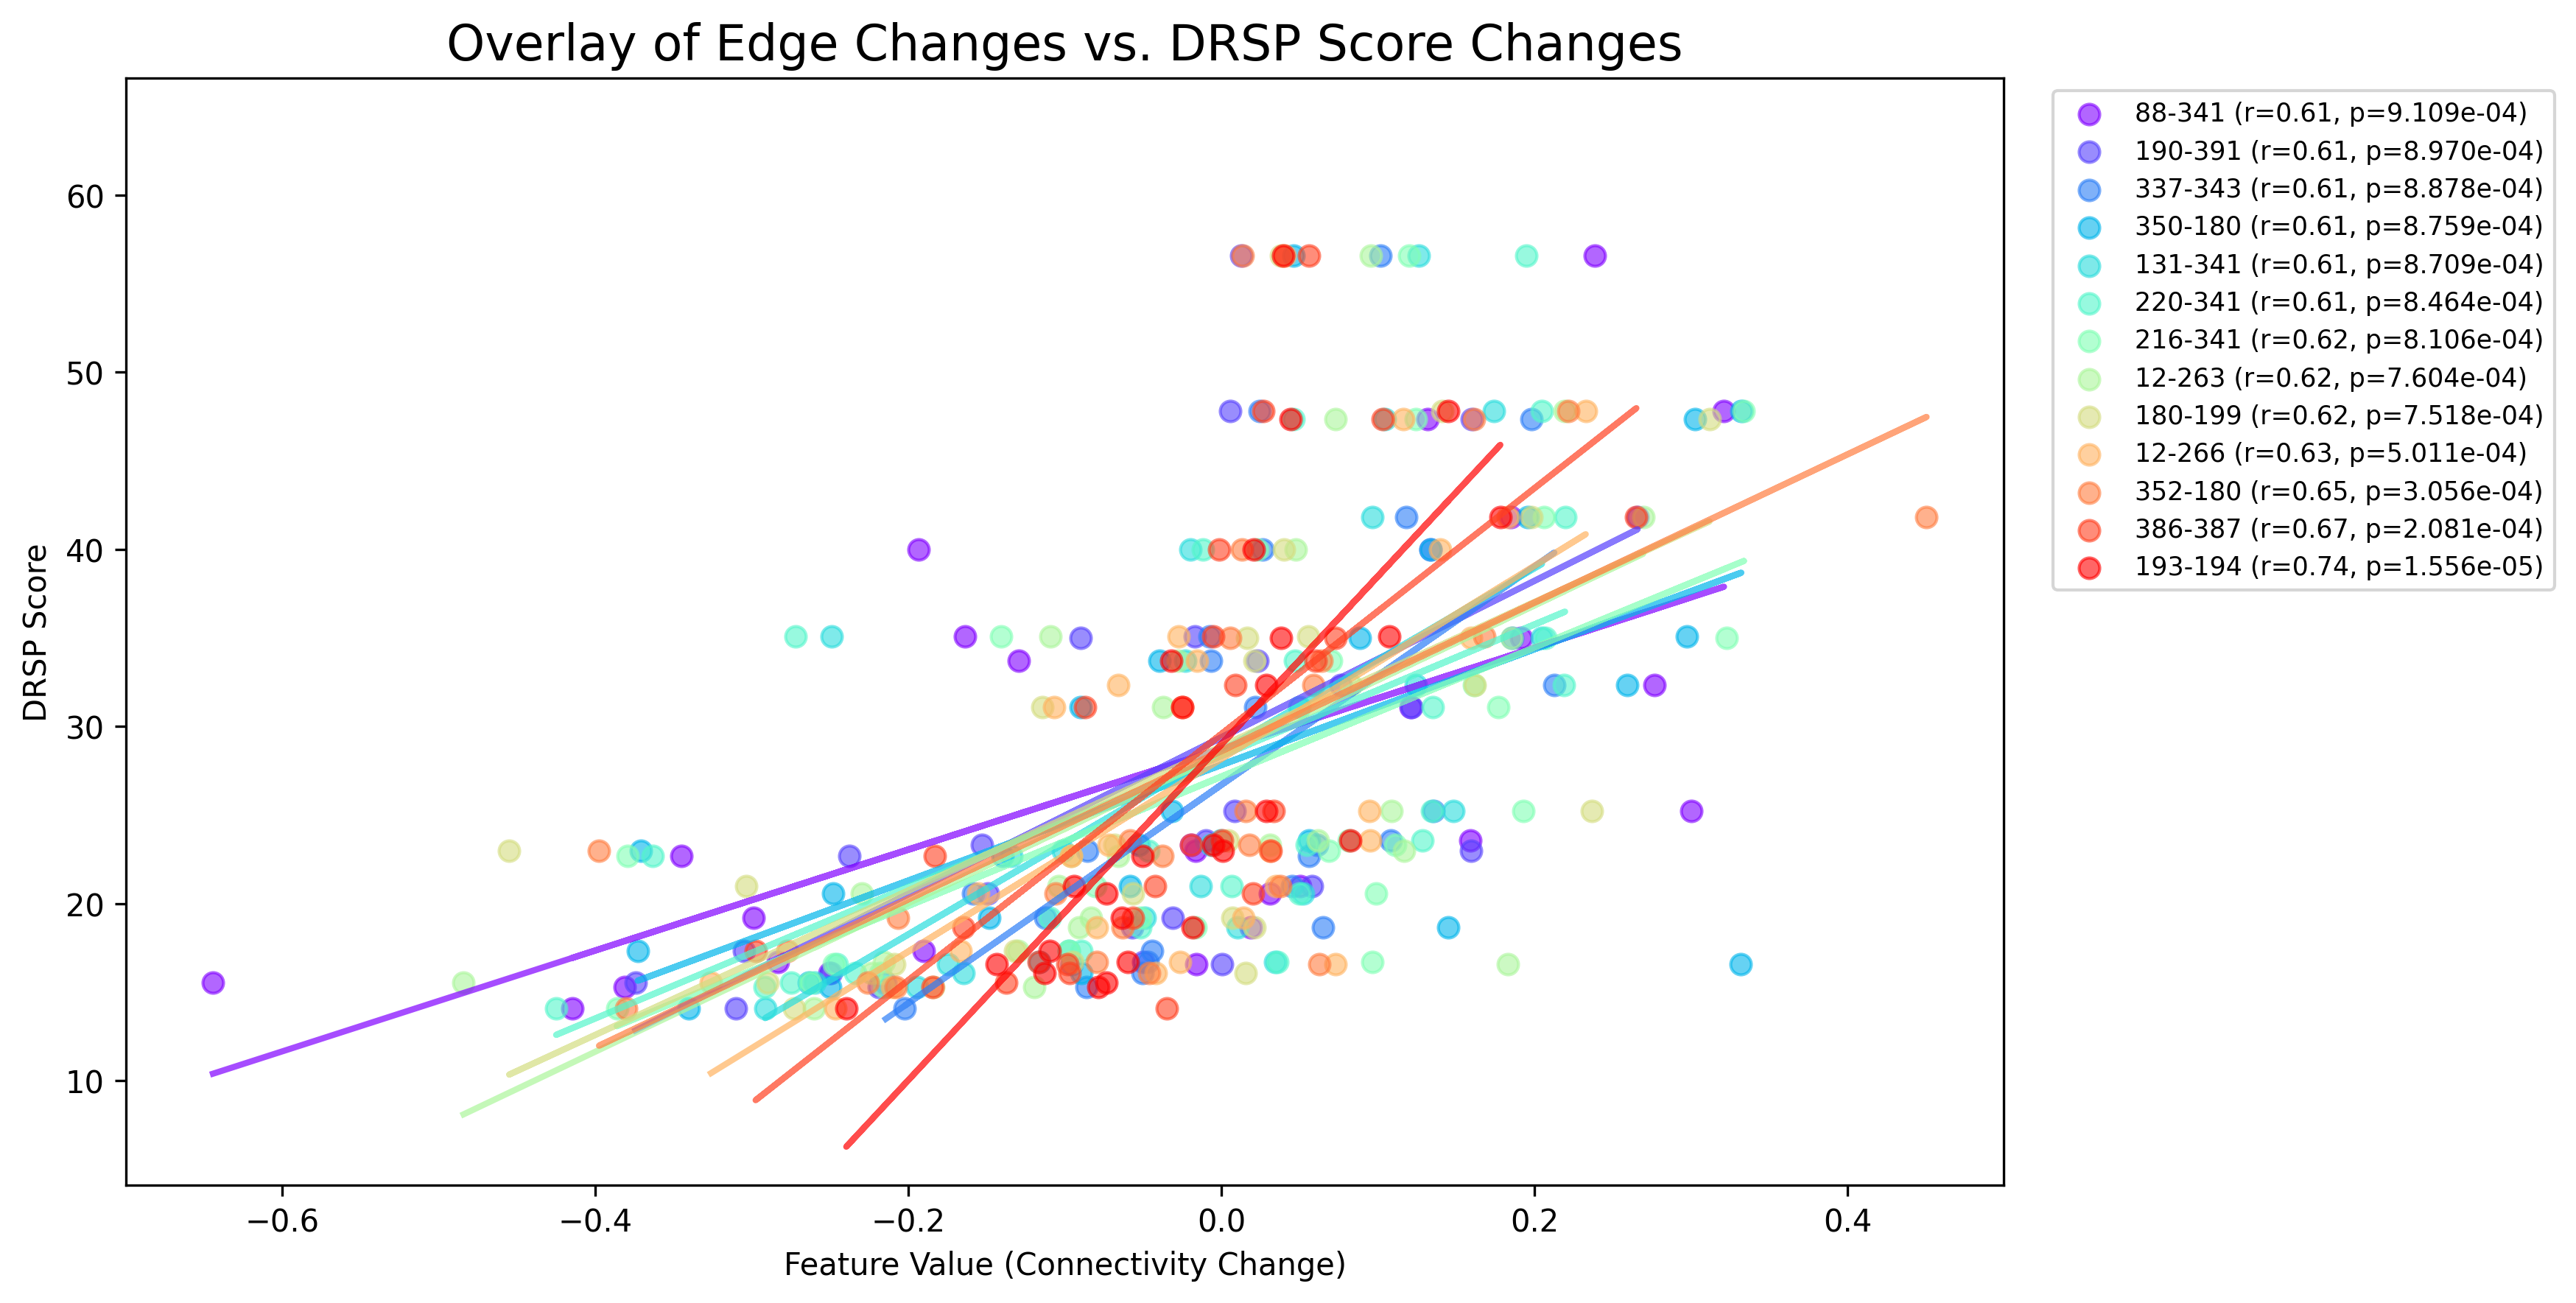

In [55]:
# Compute r-values for sorting
r_values = []
for index in significant_indices_001[:13]:
    feature_data = brain_data_flattened[:, index]
    drsp_scores = Y.flatten()
    
    # Compute Pearson correlation
    corr, _ = pearsonr(feature_data, drsp_scores)
    r_values.append((index, corr))

# Sort the r_values by correlation in ascending order (smallest to largest)
sorted_r_values = sorted(r_values, key=lambda x: x[1])  # Sort by the second item (r-value)

plt.figure(figsize=(12, 6), dpi=300)  # Adjust the aspect ratio to be wide but not too wide

# Get a colormap to assign a different color for each feature
colors = cm.rainbow(np.linspace(0, 1, len(sorted_r_values)))

# Overlay each scatter plot with a different color, now in order of r-value
for i, (index, corr) in enumerate(sorted_r_values):
    feature_data = brain_data_flattened[:, index]
    drsp_scores = Y.flatten()
    
    # Compute line of best fit
    slope, intercept, r_value, p_value, std_err = linregress(feature_data, drsp_scores)
    line_of_best_fit = slope * feature_data + intercept
    
    # Plot each feature with a different color
    plt.scatter(feature_data, drsp_scores, s=45, alpha=0.6, color=colors[i], label=f'{node_pairs[index][0]}-{node_pairs[index][1]} (r={corr:.2f}, p={p_value:.3e})')
    
    # Plot the line of best fit
    plt.plot(feature_data, line_of_best_fit, color=colors[i], linestyle='-', linewidth=2, alpha=0.7)

# Set x-axis range to [-0.7, 0.7]
plt.xlim([-0.7, 0.5])

# Keep the y-axis limits as before
plt.ylim([np.min(Y) - 10, np.max(Y) + 10])

# Add labels and title
plt.xlabel('Feature Value (Connectivity Change)')
plt.ylabel('DRSP Score')
plt.title('Overlay of Edge Changes vs. DRSP Score Changes', fontsize=16)

# Add a legend to distinguish the features, sorted by r-value
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize='small')

# Show the plot
plt.tight_layout()
plt.show()


In [10]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm
import numpy as np

# Prepare data
Y = df['DRSP Total'].values.reshape(-1, 1)  # Assuming Y is already defined correctly
brain_data_flattened = np.array(df['Unique_Changes'].tolist()).reshape(len(df), -1)  # Flattened data

# Feature selection at p-value threshold of 0.005
p_threshold = 0.005
significant_indices_005 = np.where(p_values < p_threshold)[0]
brain_data_thresholded_005 = brain_data_flattened[:, significant_indices_005]

# Ensure that shape of thresholded data is as expected
print(f"\nP-value threshold: {p_threshold}")
print(f"Shape of thresholded brain data: {brain_data_thresholded_005.shape}")

# Prepare X and y
X = brain_data_thresholded_005
y = Y.flatten()

# Initialize Lasso and Ridge with cross-validation
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000)
ridge_cv = RidgeCV(cv=5)

# Fit Lasso model with progress tracking
print("Fitting Lasso model with cross-validation...")
for _ in tqdm(range(1), desc="Lasso Progress"):
    lasso_cv.fit(X, y)

# Predict on the training data to evaluate Lasso performance
y_pred_lasso = lasso_cv.predict(X)

# Calculate performance metrics for Lasso
r2_score_lasso = r2_score(y, y_pred_lasso)
mse_lasso = mean_squared_error(y, y_pred_lasso)
n_nonzero_features_lasso = np.sum(lasso_cv.coef_ != 0)

print(f"\nLasso Regression Results:")
print(f"R^2 Score on Full Dataset: {r2_score_lasso:.4f}")
print(f"Mean Squared Error on Full Dataset: {mse_lasso:.4f}")
print(f"Number of Non-Zero Features Selected by Lasso: {n_nonzero_features_lasso}")

# Fit Ridge model with progress tracking
print("\nFitting Ridge model with cross-validation...")
for _ in tqdm(range(1), desc="Ridge Progress"):
    ridge_cv.fit(X, y)

# Predict on the training data to evaluate Ridge performance
y_pred_ridge = ridge_cv.predict(X)

# Calculate performance metrics for Ridge
r2_score_ridge = r2_score(y, y_pred_ridge)
mse_ridge = mean_squared_error(y, y_pred_ridge)

print(f"\nRidge Regression Results:")
print(f"R^2 Score on Full Dataset: {r2_score_ridge:.4f}")
print(f"Mean Squared Error on Full Dataset: {mse_ridge:.4f}")



P-value threshold: 0.005
Shape of thresholded brain data: (26, 233)
Fitting Lasso model with cross-validation...


Lasso Progress: 100% 1/1 [00:00<00:00,  2.86it/s]



Lasso Regression Results:
R^2 Score on Full Dataset: 0.5680
Mean Squared Error on Full Dataset: 57.4761
Number of Non-Zero Features Selected by Lasso: 6

Fitting Ridge model with cross-validation...


Ridge Progress: 100% 1/1 [00:00<00:00, 39.09it/s]


Ridge Regression Results:
R^2 Score on Full Dataset: 0.5422
Mean Squared Error on Full Dataset: 60.9019


In [25]:
# Assuming max_cluster_sizes contains the cluster sizes from permutations
# and observed_cluster_sizes contains the sizes of clusters from the observed data

# Calculate the largest observed cluster size
largest_observed_cluster_size = max(observed_cluster_sizes)

# Calculate the empirical p-value
p_value_empirical = np.mean(np.array(max_cluster_sizes) >= largest_observed_cluster_size)
print(f"Empirical p-value for the largest observed cluster: {p_value_empirical:.4f}")


Empirical p-value for the largest observed cluster: 0.1200
